## ARIMA를 활용한 코스피지수 시계열 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# from pykrx import stock
# df = stock.get_index_ohlcv_by_date("20150101", "20201231", "1028") #KOSPI코드
# df = df.reset_index()
# print(df.head(2))
# df.to_csv("kospi.csv", index=False)

In [3]:
df = pd.read_csv('./datasets/kospi.csv')

df = df.iloc[:-5].copy()  #일주일치 빼고 간다.

In [16]:
print(df.shape)
df['종가'].tail()

(1470, 7)


1465    372.53
1466    372.00
1467    371.55
1468    372.18
1469    366.43
Name: 종가, dtype: float64

In [5]:
df['날짜'].min(),  df['날짜'].max()

('2015-01-02', '2020-12-22')

## <font color=red> 시계열 데이터 : 날짜 데이터가 연속적일 경우의 데이터, shuffle 금지 ******</font>

In [6]:
close_df = df[['날짜','종가']]
close_df = close_df.sort_values('날짜')
close_df = close_df.set_index('날짜')

In [7]:
close_df.head()

,종가
날짜,
2015-01-02,244.79
2015-01-05,244.26
2015-01-06,239.93
2015-01-07,240.53
2015-01-08,243.94


<AxesSubplot:xlabel='날짜'>

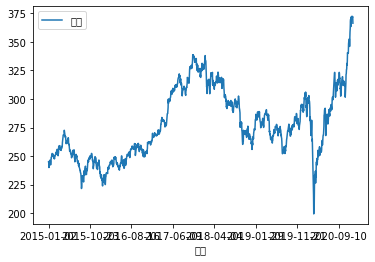

In [8]:
close_df.plot()

* 정상성을 갖지 않는다 (평균, 분산이 일정하지 않다)

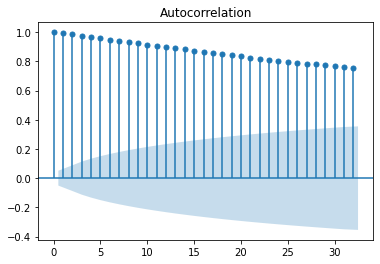

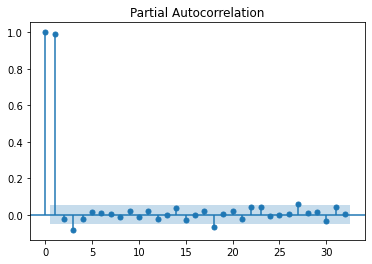

In [9]:
plot_acf(close_df)
plot_pacf(close_df)   # Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 15 must be < 15.
plt.show()

* PACF  : AR(p) == X 
* ACF : MA(q) == 1
* 지수 데이터는 MA 모델이 적합하다

# 차분 후 정상성을 띠는지 확인

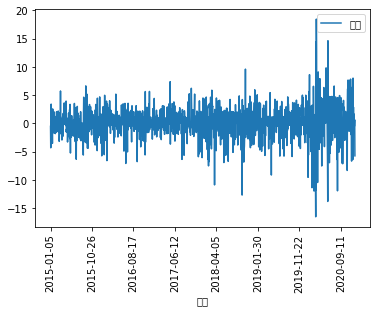

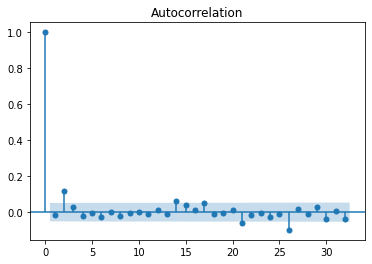

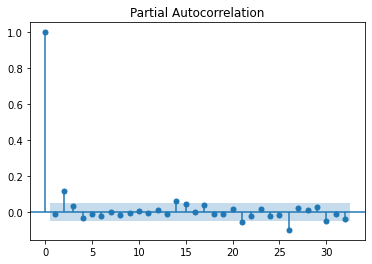

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1 = close_df.diff(periods=1).iloc[1:]
diff_1.plot()
plt.xticks(rotation =90)
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

* ARIMA(p ,d, q) : 날짜를 1일 차분한 결과 평균이 일정 --> d값 1
* ACF  : MA(p) == 1 ~ 2 
* PACF : AR(q) == 1 ~ 2
* 지수 데이터는 1차 차분한 데이터를 사용할 경우 :: AR인경우 p값을 1~2로 MA의 q값을 1~2로 사용하는 모델이 적합하다


In [11]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# model = ARIMA(close_df, order=(1,1,1))
# model = ARIMA(close_df, order=(2,1,1))
# model = ARIMA(close_df, order=(1,1,2))
model = ARIMA(close_df, order=(2,1,2))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.종가   No. Observations:                 1469
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3596.841
Method:                       css-mle   S.D. of innovations              2.800
Date:                Thu, 21 Oct 2021   AIC                           7205.682
Time:                        13:29:25   BIC                           7237.436
Sample:                             1   HQIC                          7217.524
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0818      0.082      0.999      0.318      -0.079       0.242
ar.L1.D.종가     0.2227      0.202      1.100      0.271      -0.174       0.620
ar.L2.D.종가    -0.1433      0.177     -0.811      0.4

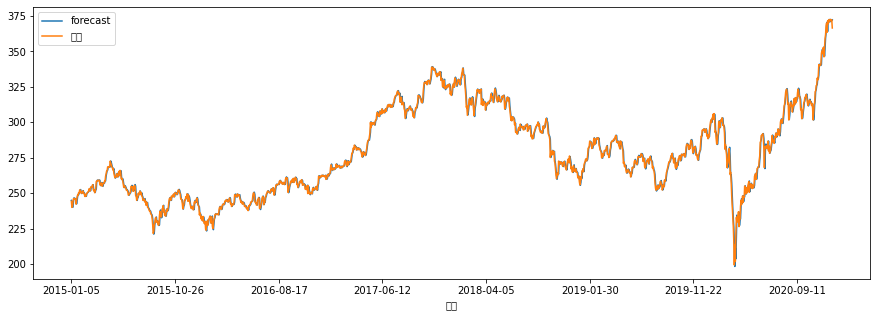

In [12]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

In [13]:
fore = arima_res.forecast(steps=1) # 1 : 다음날 맞춰봐 
#  예측값, stderr,   upper bound~lower bound 
print(fore)
print(np.array(fore[0])/1000)

(array([366.63484981]), array([2.79979371]), array([[361.14735497, 372.12234464]]))
[0.36663485]


In [14]:
# 2020-12-30	381.21	390.04	379.14	389.29	236858021	12816206027510

# 5일치 예측
<pre>
1465    372.53
1466    372.00
1467    371.55
1468    372.18
1469    366.43

In [26]:
fore = arima_res.forecast(steps=5) # 5일치 맞춰봐 
#  예측값, stderr,   upper bound~lower bound 
# print(fore)

print('5일 예측지수', np.array(fore[0])/1000 * 1000)
print('예측평균', np.array([372.53,372.00,371.55,372.18,366.43]).mean())
print('실제평균', (np.array(fore[0])/1000 * 1000).mean())

5일 예측지수 [366.63484981 366.03658191 365.94931348 366.09090222 366.21024836]
예측평균 370.938
실제평균 366.18437915257215


In [31]:
from sklearn.model_selection import TimeSeriesSplit
tfold = TimeSeriesSplit(n_splits=5)
for train , test in tfold.split(close_df):
    print(len(train), len(test))
          

245 245
490 245
735 245
980 245
1225 245
